In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier 
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, recall_score

In [2]:
df = pd.read_csv('data/heart_2020_cleaned_binary.csv')

In [3]:
df.head()

,Unnamed: 0,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,...,Asian,Black,Hispanic,Other,White,Excellent_Health,Fair_Health,Good_Health,Poor_Health,Very_Good_Health
0,0,0,16.60,1,0,0,3.0,30.0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,1,0,20.34,0,0,1,0.0,0.0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,2,0,26.58,1,0,0,20.0,30.0,0,1,...,0,0,0,0,1,0,1,0,0,0
3,3,0,24.21,0,0,0,0.0,0.0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,4,0,23.71,0,0,0,28.0,0.0,1,0,...,0,0,0,0,1,0,0,0,0,1


([<matplotlib.patches.Wedge at 0x20ff2049880>,
 [Text(6.735557395310444e-17, 1.1, 'Has Heart Disease'),
  Text(-2.0206672185931328e-16, -1.1, 'Does Not Have Heart Disease')])

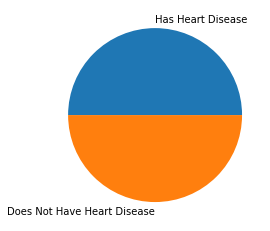

In [4]:
# Features that will be kept in models
keepThese = ['DiffWalking', 'PhysicalHealth', 'Diabetic_Yes', 'Stroke', 'Poor_Health', 'Fair_Health', '80 or older', 'Smoking', 'KidneyDisease']

# Separating data into Features and Targets
X = df[keepThese]
Y = df['HeartDisease']

# Balancing the data
balancer = RandomUnderSampler()
X, Y = balancer.fit_resample(X, Y)

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

# Scaling the data for better behavior with models
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Plotting Balanced Data
heart_labels = ['Has Heart Disease', 'Does Not Have Heart Disease']
plt.pie([len(df['HeartDisease'] == 1), len(df['HeartDisease'] == 0)], labels = heart_labels)

In [20]:
def get_performance(model_type, params, model_name):

    # Create Model
    model = model_type()
    
    # Cross Validation of Model
    model_cv = cross_validate(model, X_train, y_train, cv=3, scoring='f1')

    # Finding Best Parameters
    model_clf = GridSearchCV(model, param_grid=params, cv=3, scoring='f1')
    model_clf.fit(X_train, y_train)
    model_best_params = model_clf.best_params_

    # Calculating Performance
    model_best = model_type(**model_best_params)
    model_best.fit(X_train, y_train)
    model_best_preds = model_best.predict(X_test)
    model_best_f1 = f1_score(y_test, model_best_preds)
    model_best_recall = recall_score(y_test, model_best_preds)

    # Displaying Output
    print(f"Cross Validation Accuracy: {model_cv['test_score'].mean()}")
    print(f"{model_name} GridSearchCV Best Parameters: {model_best_params}")
    print(f"{model_name} F1 Score: {model_best_f1}")
    print(f"{model_name} Recall: {model_best_recall}")

### Logistic Regression

In [21]:
# Parameters
params = {'solver': ['liblinear', 'saga'], 'C':[10**i for i in range(0,11)], 'penalty':['l1','l2']}

# Performance
get_performance(LogisticRegression, params, 'Logistic Regression')

Cross Validation Accuracy: 0.6966853866070251
Logistic Regression GridSearchCV Best Parameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression F1 Score: 0.7056306525333074
Logistic Regression Recall: 0.6577229876722263


### KNN

In [25]:
# Parameters
params = {'n_neighbors': [i for i in range(5, 11)], 'leaf_size': [i for i in range(30, 70, 10)]}

# Performance
get_performance(KNeighborsClassifier, params, 'KNN')

Cross Validation Accuracy: 0.6652689294118198
KNN GridSearchCV Best Parameters: {'leaf_size': 60, 'n_neighbors': 9}
KNN F1 Score: 0.6946679139382601
KNN Recall: 0.6731327048585932


### Decision Tree

In [23]:
# Parameters
params = {'criterion' : ["entropy"], 'min_samples_split': [i for i in range(30, 70, 10)], 'min_samples_leaf': [i for i in range(2,6,1)], 'max_depth': [i for i in range(12,17,1)]}

# Performance
get_performance(tree.DecisionTreeClassifier, params, 'Decision Tree')

Cross Validation Accuracy: 0.6948549914860335
Decision Tree GridSearchCV Best Parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_leaf': 5, 'min_samples_split': 60}
Decision Tree F1 Score: 0.717113783533765
Decision Tree Recall: 0.7026831036983321


### Ensemble Methods

In [24]:
ensemble = [AdaBoostClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]
ensemble_names = ['AdaBoost', 'RandomForest', 'GradientBoosting']
for i in range(len(ensemble)):
    method = ensemble[i]

    method.fit(X_train, y_train)
    method_preds = method.predict(X_test)
    f1 = f1_score(y_test, method_preds)
    recall = recall_score(y_test, method_preds)
    method.fit(X_train, y_train)

    print(f"{ensemble_names[i]} F1 Score: {f1}")
    print(f"{ensemble_names[i]} Recall: {recall}")

AdaBoost F1 Score: 0.706167571761055
AdaBoost Recall: 0.6600797679477882
RandomForest F1 Score: 0.7121310261867306
RandomForest Recall: 0.6976069615663524
GradientBoosting F1 Score: 0.7145961265942372
GradientBoosting Recall: 0.6856417693981146
